# Voronoi-Otsu-labeling
This workflow for image segmentation is a rather simple and yet powerful approach, e.g. for detecting and segmenting nuclei in fluorescence micropscopy images. A nuclei marker such as nuclei-GFP, DAPI or histone-RFP in combination with various microscopy techniques can be used to generate images of suitable kind.

In [7]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import napari_segment_blobs_and_things_with_membranes as nsbatwm

To demonstrate the workflow, we're using image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC022):
We used image set BBBC022v1 [Gustafsdottir et al., PLOS ONE, 2013](http://dx.doi.org/10.1371/journal.pone.0080999), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083).

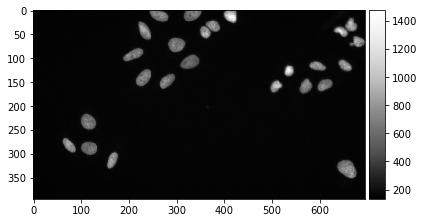

In [31]:
input_image = imread("../../data/BBBC022/IXMtest_A02_s9.tif")[:,:,0]
imshow(input_image, cmap="Greys_r")

## Applying the algorithm
Voronoi-Otsu-labeling is a command in clesperanto, which asks for two sigma parameters. The first sigma controls how close detected cells can be (`spot_sigma`) and second controls how precise segmented objects are outlined (`outline_sigma`).

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
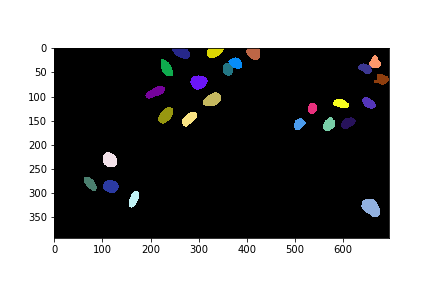

In [19]:
sigma_spot_detection = 5
sigma_outline = 1

segmented = nsbatwm.voronoi_otsu_labeling(input_image, 
                                          spot_sigma=sigma_spot_detection, 
                                          outline_sigma=sigma_outline
                                         )
segmented

The algorithm is also implemented in [clesperanto](https://github.com/clEsperanto/pyclesperanto_prototype), a GPU-accelerated image processing library enabling fast 2D/3D image processing.

In [8]:
import pyclesperanto_prototype as cle

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
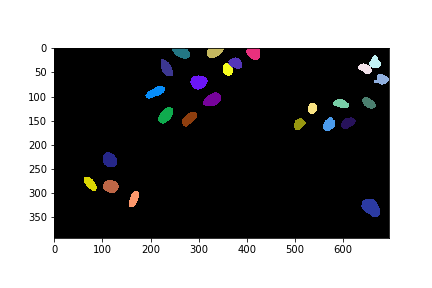

In [20]:
segmented_cle = cle.voronoi_otsu_labeling(input_image, 
                                          spot_sigma=sigma_spot_detection, 
                                          outline_sigma=sigma_outline
                                         )
segmented_cle

## How does it work?
The Voronoi-Otsu-Labeling workflow is a combination of Gaussian blur, spot detection, thresholding and binary watershed. The interested reader might want to see the [open source code](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/pyclesperanto_prototype/_tier9/_voronoi_otsu_labeling.py). The approach is similar to applying a seeded watershed to a binary image, e.g. in [MorphoLibJ](https://imagej.net/plugins/marker-controlled-watershed) or [scikit-image](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed). However, the seeds are computed automatically and cannot be passed.

For demonstration purposes we do that only on the 2D cropped image shown above. If this algorithm is applied to 3D data, it is recommended to make it isotropic first.

cl.OCLArray([[147., 155., 160., ..., 163., 169., 177.],
       [149., 159., 159., ..., 172., 178., 190.],
       [149., 153., 155., ..., 183., 189., 208.],
       ...,
       [162., 164., 165., ..., 164., 159., 156.],
       [163., 158., 162., ..., 156., 157., 161.],
       [155., 159., 155., ..., 164., 158., 155.]], dtype=float32)
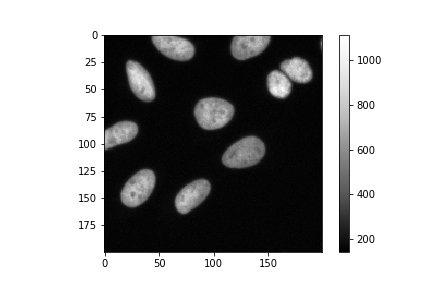
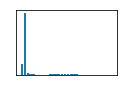

In [21]:
image_to_segment = cle.asarray(input_image[0:200, 200:400])
image_to_segment

As a first step, we blur the image with a given sigma and detect maxima in the resulting image. 

cl.OCLArray([[153.59329, 153.94395, 154.30336, ..., 196.62846, 202.50084,
        208.28029],
       [154.18848, 154.467  , 154.75429, ..., 204.0801 , 211.23354,
        218.28055],
       [154.802  , 155.0074 , 155.22124, ..., 212.22923, 220.78998,
        229.23041],
       ...,
       [160.02101, 160.29898, 160.57854, ..., 159.92561, 159.73663,
        159.53217],
       [159.78874, 160.11214, 160.43704, ..., 159.71596, 159.49596,
        159.25792],
       [159.56662, 159.93698, 160.30872, ..., 159.51465, 159.26537,
        158.99547]], dtype=float32)
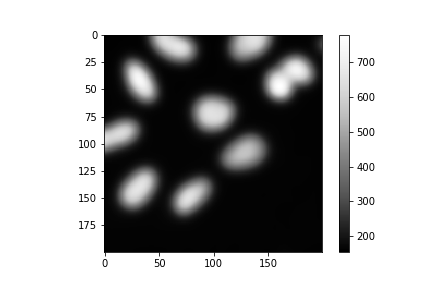
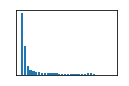

In [22]:
blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_spot_detection, sigma_y=sigma_spot_detection, sigma_z=sigma_spot_detection)
blurred

number of detected spots 30.0


cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
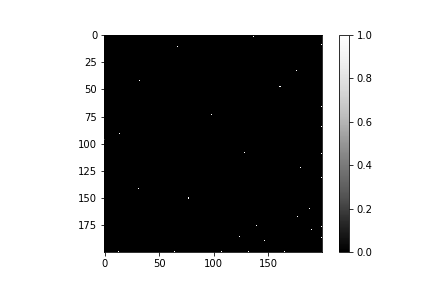
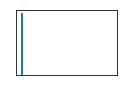

In [23]:
detected_spots = cle.detect_maxima_box(blurred, radius_x=0, radius_y=0, radius_z=0)

number_of_spots = cle.sum_of_all_pixels(detected_spots)
print("number of detected spots", number_of_spots)

detected_spots

Furthermore, we start again from the cropped image and blur it again, with a different sigma. Afterwards, we threshold the image using [Otsu's thresholding method (Otsu et al 1979)](https://doi.org/10.1109%2FTSMC.1979.4310076).

cl.OCLArray([[150.2991 , 153.93951, 155.4161 , ..., 169.1814 , 173.59644,
        178.86278],
       [151.423  , 154.30101, 155.58055, ..., 175.77574, 181.97047,
        189.15413],
       [153.848  , 154.62854, 155.09294, ..., 184.2515 , 195.65831,
        207.65991],
       ...,
       [160.11455, 160.66406, 160.30243, ..., 160.70787, 159.32138,
        158.23988],
       [159.82332, 160.00572, 160.33269, ..., 160.57376, 158.8891 ,
        158.00783],
       [157.75456, 158.46873, 160.21451, ..., 161.19041, 158.82317,
        157.16649]], dtype=float32)
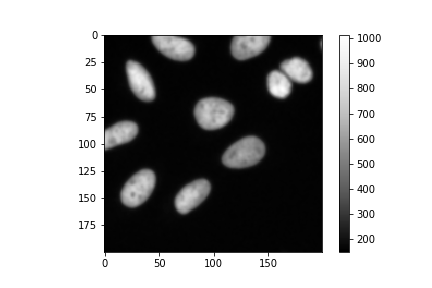
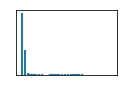

In [24]:
blurred2 = cle.gaussian_blur(image_to_segment, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)
blurred2

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
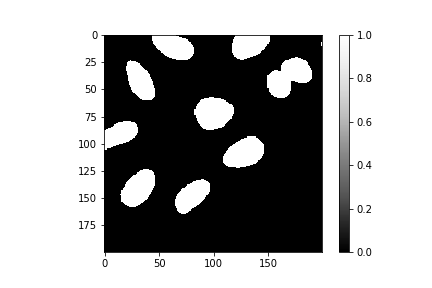
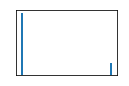

In [25]:
binary = cle.threshold_otsu(blurred2)

binary

Afterwards, we take the binary spots image and the binary segmentation image and apply a `binary_and` operation to exclude spots which were detected in the background area. Those likely corresponded to noise.

number of selected spots 12.0


cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
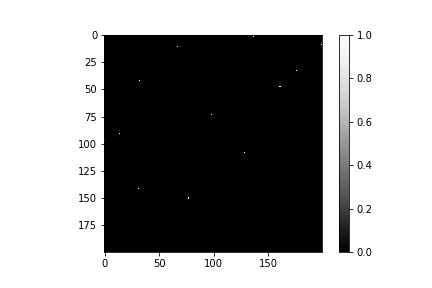
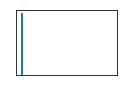

In [26]:
selected_spots = cle.binary_and(binary, detected_spots)

number_of_spots = cle.sum_of_all_pixels(selected_spots)
print("number of selected spots", number_of_spots)

selected_spots

Next, we separate the image space between the selected spots using a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram#References) which is limited to the positive pixels in the binary image.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
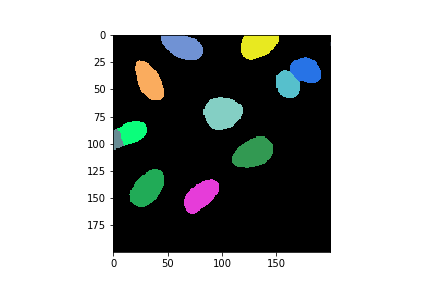

In [27]:
labeling = cle.masked_voronoi_labeling(selected_spots, binary)

labeling